In [1]:
# Librerías
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt

# Funciones

In [2]:
def read_histogram(filename):
  values = []
  with open(filename) as f:
    for i, line in enumerate(f):
      if i == 0 :
        # Leo tamaños
        shape = np.int_(line.split())
      else :
        # Leo valores
        values.append(np.int_(line.split())[0])
  values = np.array(values, dtype = np.float64)
  # Regreso histograma como tensor
  return values.reshape(shape)

In [3]:
def get_h_j(h):
  '''
  c = [r, g, b]
  r \in B_1
  g \in B_2
  b \in B_3
  '''
  b1, b2, b3 = h.shape
  h_j = [ (h[i][j][k], np.array([i,j,k]))
          for i in range(b1)
          for j in range(b2)
          for k in range(b3)
        ]
  return h_j

In [4]:
def f(x1, x2, params):
  '''
  Calcula valor de la función f
  Parámetros
  -----------
    x1 : Vector alpha
    x2 : vetor mu
    params: Diccionario de valores fijos de f
            sigma : valor de desviación estándar
            h_j   : histograma de clases
  Regresa
  -----------
    f_ : Evaluación f(x1,x2, h_j, sigma)
  '''
  sigma = params['sigma']
  h_j   = params['h_j']

  # Reviso dimensiones
  if len(x1.shape) == 1:
    alpha = x1
    mu    = x2
  else:
    alpha = x2
    mu    = x1

  f_ = 0.0
  for h_c, c in h_j:
    sum2  = np.sum( alpha * np.exp(-(np.linalg.norm(c - mu, axis = 1)**2) / (2.0 *sigma**2)) )
    f_   += (h_c - sum2) ** 2
  return np.float64(f_)

def f_grad_alpha(alpha, mu, params):
  '''
  Calcula gradiente de f respecto a vector alpha
  Parámetros 
  -----------
    alpha  : vector de valores a evaluar
    mu     : vector fijo de valores mu
    params : Diccionario de valores para \nabla f
            sigma : valor de desviación estándar
            h_j   : histograma de clases
  Regresa
  -----------
    f_grad : Evaluación \nabla f(alpha, mu, h_j, sigma)
  '''
  sigma = params['sigma']
  hc_c  = params['h_j']

  f_grad = np.zeros(alpha.shape, dtype = np.float64)

  for k in range(f_grad.shape[0]):
    sum1 = 0.0
    for h_c, c in hc_c:
      sum2 = np.sum(alpha * np.exp( -np.linalg.norm(c - mu, axis = 1)**2 / (2.0 *sigma**2) ) )
      e_k  = np.exp(-np.linalg.norm(c - mu[k])**2 / (2*sigma**2) )
      sum1 +=  (h_c - sum2) * e_k
    f_grad[k] = -2.0 * sum1
  return f_grad

def f_grad_mu(mu, alpha, params):
  '''
  Calcula gradiente de f respecto a vector mu
  Parámetros 
  -----------
    alpha  : vector fijo de valores alpha
    mu     : vector de valores mu
    params : Diccionario de valores para \nabla f
            sigma : valor de desviación estándar
            h_j   : histograma de clases
  Regresa
  -----------
    f_grad : Evaluación \nabla f(alpha, mu, h_j, sigma)
  '''
  sigma = params['sigma']
  hc_c  = params['h_j']   
  
  f_grad = np.zeros(mu.shape, dtype = np.float64)

  for k in range(f_grad.shape[0]):
    sum1 = 0.0
    for h_c, c in hc_c:
      sum2    = np.sum(alpha * np.exp( -np.linalg.norm(c - mu, axis=1 **2) / (2*sigma**2) ) )
      e_k     = np.exp(-(np.linalg.norm(c - mu[k])**2) / (2*sigma**2))
      sum1   += (h_c - sum2) * (alpha[k] * e_k * (c - mu[k]))
    f_grad[k] = -(2.0 / sigma**2 )* sum1
    
  return f_grad

# Descenso Gradiente

In [5]:
def back_tracking (x_k, x_fixed, d_k, f, f_grad, alpha_ = 0.1, ro = 0.9, c1 = 1e-4, params = {}) :
    '''
    Calcula tamaño de paso alpha
    
        Parámetros
        -----------
            x_k     : Vector de valores [x_1, x_2, ..., x_n]
            d_k     : Dirección de descenso
            f       : Función f(x)
            f_grad  : Función que calcula gradiente
            alpha   : Tamaño inicial de paso
            ro      : Ponderación de actualización
            c1      : Condición de Armijo
        Regresa
        -----------
            alpha_k : Tamaño actualizado de paso
    '''
    # Inicialización
    alpha_k = alpha_
    # Repetir hasta que se cumpla la condición de armijo
    while f(x_k + alpha_k * d_k, x_fixed, params) > f(x_k, x_fixed, params) + c1 * alpha_k * f_grad(x_k, x_fixed,  params).flatten().dot(d_k.flatten()) :
        alpha_k = ro * alpha_k
    return alpha_k

In [6]:
# Descenso Gradiente
def des_grad (params = []) :
  # Cargo parámetros
  x_k        = params['x_0']
  x_fixed    = params['x_fixed']
  sigma      = params['sigma']
  h_j        = params['h_j']

  x_k_next   = None
    
  f          = params['f']
  f_grad     = params['f_grad']
  max_iter   = params['max_iter']
  tau_x      = params['tau_x']
  tau_f      = params['tau_f']
  tau_f_grad = params['tau_grad']

  # Parámetros para evaluación de f
  sub_params = params['f_params']
        
  # Guardo Parámetros
  f_hist = []
  f_hist.append(f(x_k, x_fixed, params = sub_params))

  g_hist = []
  g_hist.append(np.linalg.norm(f_grad(x_k, x_fixed, params = sub_params)))
    
  # Identifico función para paso
  if (params['method'] == 'BackTracking') :
    alpha = params['BackTracking']['alpha']
    ro    = params['BackTracking']['ro']
    c1    = params['BackTracking']['c1']
  elif (params['method'] == 'Fixed') :
    alpha = params['alpha']
  else :
    print('Non Method for step size. Exit...')
    return  
  # Comienza descenso
  k = 0 
  while True:
    # Calculo gradiente
    d_k = - f_grad(x_k, x_fixed, sub_params)        
    # Cálculo tamaño de paso ---------------------------------------------------------
    if (params['method'] == 'BackTracking') :
      alpha_k = back_tracking(x_k, x_fixed, d_k, f, f_grad, alpha, ro, c1, sub_params)
    elif (params['method'] == 'Fixed') :
      alpha_k = alpha
    # -------------------------------------------------------------------------------- 
    # Calculo siguiente valor x_k+1
    x_k_next = x_k + alpha_k * d_k   
        
    # Guardo Parámetros
    f_hist.append(f(x_k_next, x_fixed,  sub_params))
    g_hist.append(np.linalg.norm(f_grad(x_k_next, x_fixed, params = sub_params).flatten()))

    # Criterios de paro -------------------------------------------------------------------
    if (k > max_iter) :
      #print('Iteraciones: ', k, ' , valor: ', x_k)
      break 
    if np.linalg.norm(x_k_next - x_k)/max(np.linalg.norm(x_k), 1.0) < tau_x :
      #print('Iteraciones: ', k, ' , valor: ', x_k)
      break      
    g_k = np.linalg.norm(f_grad(x_k_next, x_fixed, sub_params).flatten())
    if g_k < tau_f_grad :
      #print('Iteraciones: ', k, ' , valor: ', x_k)
      break
    # -------------------------------------------------------------------------------------
    # Actualización   
    x_k = x_k_next       
    k   = k + 1
    # print('iteración: ', k, 'Norma de gradiente: ', g_k)
  return f_hist, g_hist, x_k_next

# Optimización Iterativa

In [94]:
def optimization_iter (params) :
  # Lectura de Parámetros
  alpha      = params['alpha']
  mu         = params['mu']
  hc_c       = params['h_j']
  sigma      = params['sigma']
  iters      = params['iters']
  tau_x      = params['tau_x']
  tau_f      = params['tau_f']
  tau_f_grad = params['tau_grad']

  f_params = { 'sigma' : sigma, 
                'h_j'   : hc_c
             }
  # Paŕametros para tamaño de paso
  method = params['method']
  if method == 'BackTracking' :
    method_dic = {'alpha'    : params['BackTracking']['alpha'],
                  'ro'       : params['BackTracking']['ro'],
                  'c1'       :  params['BackTracking']['c1']
                  }
  elif method == 'Fixed' :
    method_dic = {'alpha' : params['Fixed']['alpha']}
  else :
    print('Non implemented.')
    return
  
  f_k    = f(alpha, mu, f_params)
  f_prev = f_k

  # historial de valores
  f_hist = []
  g_hist = []

  k = 0
  while k < iters :
    # Optimización para Alpha
    params_alpha = {'x_0'      : alpha,
                    'x_fixed'  : mu,
                    'h_j'      : hc_c,
                    'sigma'    : sigma, 
                    'f'        : f,
                    'f_grad'   : f_grad_alpha,
                    'tau_x'    : tau_x,
                    'tau_f'    : tau_f,
                    'tau_grad' : tau_f_grad,
                    'method'   : method,
                    'max_iter' : params[method]['max_iter'],
                    method     : method_dic,
                    'f_params' : f_params
          }
    print('Optimización para alpha')
    alpha_prev           = alpha
    f_log, g_log, alpha  = des_grad(params_alpha)
    f_hist              += f_log
    g_hist              += g_log

    params_mu = {'x_0'         : mu,
                    'x_fixed'  : alpha,
                    'h_j'      : hc_c,
                    'sigma'    : sigma, 
                    'f'        : f,
                    'f_grad'   : f_grad_mu,
                    'tau_x'    : tau_x,
                    'tau_f'    : tau_f,
                    'tau_grad' : tau_f_grad,
                    'method'   : method,
                    'max_iter' : params[method]['max_iter'],
                    method     : method_dic,
                    'f_params' : f_params          
                }
    
    print('Optimización para mu')
    mu_prev           = mu
    f_log, g_log, mu  = des_grad(params_mu)
    f_hist           += f_log
    g_hist           += g_log

    # Acutalización
    f_prev = f_k
    f_k    = f(alpha, mu, f_params)
    k     += 1

    print('Iteración: ', k,',Valor de f: ', f_k)

    # Criterios de Paro ---------------------------------------------
    if np.abs(f_k - f_prev) < tau_f :
      print('Iteraciones :', k)
      break
    g_k = np.linalg.norm(f_grad_alpha(alpha, mu, f_params).flatten())
    if g_k < tau_f_grad :
      print('Iteraciones: ', k)
      break
    g_k = np.linalg.norm(f_grad_mu(mu, alpha, f_params).flatten())
    if g_k < tau_f_grad :
      print('Iteraciones: ', k)
      break
    # ---------------------------------------------------------------

  return alpha, mu, np.array(f_hist), np.array(g_hist)

# Segmentación

## Segmentación con F

In [33]:
RED  = 1
BLUE = 2

def rgb_to_class(rgb, n_bins):
  x = int(rgb[0] / 256.0 * n_bins)
  y = int(rgb[1] / 256.0 * n_bins)
  z = int(rgb[2] / 256.0 * n_bins)
  return np.array([x, y, z])

def f_(alpha, mu, c, sigma = 0.2):
    exp =  np.exp(-np.linalg.norm(c - mu, axis=1)**2 / (2*sigma**2))
    s = alpha * exp
    return np.sum(s)

def F1(c, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = 0.2):
    t1 = f_(alpha_1, mu_1, c, sigma = sigma) + epsilon
    t2 = f_(alpha_1, mu_1, c, sigma = sigma) + f_(alpha_2, mu_2, c, sigma = sigma) + 2.0 * epsilon
    return t1/t2


def F2(c, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = 0.2):
    t1 = f_(alpha_2, mu_2, c, sigma = sigma) + epsilon
    t2 = f_(alpha_1, mu_1, c, sigma = sigma) + f_(alpha_2, mu_2, c, sigma = sigma) + 2.0 * epsilon
    return t1/t2

def get_c_label(c, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = 0.2):
    f1 = F1(c, alpha_1, mu_1, alpha_2, mu_2, epsilon = epsilon, sigma = sigma)
    f2 = F2(c, alpha_1, mu_1, alpha_2, mu_2, epsilon = epsilon, sigma = sigma)
    return RED if f1 < f2 else BLUE

def get_c_labels(nbins, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = 0.2):
    labels = np.zeros((nbins, nbins, nbins), dtype = np.int)
    l = m = n = nbins
    for i in range(l):
        for j in range(m):
            for k in range(n):
                c = np.array([i,j,k])
                label = get_c_label(c, alpha_1, mu_1, alpha_2, mu_2, epsilon = epsilon, sigma = sigma)
                labels[i][j][k] = label
    return labels


def segmentation(img, nbins, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = 0.1):
    labels  = get_c_labels(nbins, alpha_1, mu_1, alpha_2, mu_2, epsilon = epsilon, sigma = sigma)
    shape   = img.shape
    img_seg = img.copy()
    print('Dimensiones de imagen: ', img_seg.shape)
    for i in range(shape[0]):
        for j in range(shape[1]):
            c = rgb_to_class(img[i][j], nbins)
            label = labels[c[0], c[1], c[2]]
            img_seg[i][j][0] = 255 if label == RED else 0
            img_seg[i][j][1] = 0
            img_seg[i][j][2] = 255 if label == BLUE else 0
    return img_seg

## Segmentación con H

In [36]:
def H1(h1, h2, c, epsilon = 0.001):
  t1 = h1[c[0]][c[1]][c[2]] + epsilon
  t2 = h1[c[0]][c[1]][c[2]] + h2[c[0]][c[1]][c[2]] + 2.0 *epsilon
  return t1/t2

def H2(h1, h2, c, epsilon = 0.001):
  t1 = h2[c[0]][c[1]][c[2]] + epsilon
  t2 = h1[c[0]][c[1]][c[2]] + h2[c[0]][c[1]][c[2]] + 2.0 * epsilon
  return t1/t2

def get_c_label_h(c, hist_0, hist_1):
  h1 = H1(hist_0, hist_1, c)
  h2 = H2(hist_0, hist_1, c)
  return BLUE if h1 < h2 else RED

def get_c_labels_h(nbins, hist_0, hist_1):
  labels = np.zeros((nbins, nbins, nbins), dtype=np.int)
  for i in range(nbins):
    for j in range(nbins):
      for k in range(nbins):
        c = np.array([i,j,k])
        labels[i][j][k] = get_c_label_h(c, hist_0, hist_1)
  return labels

def histogram_segmentation(img, nbins, hist_1, hist_2):
  labels = get_c_labels_h(nbins, hist_1, hist_2)
  shape   = img.shape
  img_seg = img.copy()
  
  print('Dimensiones de imagen: ', shape)
  for i in range(shape[0]):
    for j in range(shape[1]):
      c = rgb_to_class(img[i][j], nbins)
      label = labels[c[0], c[1], c[2]]
      img_seg[i][j][0] = 255 if label == BLUE else 0
      img_seg[i][j][1] = 0
      img_seg[i][j][2] = 255 if label == RED else 0
  return img_seg

In [12]:
def plot_img(img1, img2, t ='Original', s ='Segmentation'):
    fig     = plt.figure(figsize = (8, 8))
    rows    = 1
    columns = 2
    ax1     = fig.add_subplot(rows, columns, 1)
    ax1.set_title(t)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax2     = fig.add_subplot(rows, columns, 2)
    ax2.set_title(s)
    plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    plt.show()

# Parámetros Generales

In [117]:
nbins        = 3
radial_size = 10
sigma       = 0.5

# rose.png

In [86]:
img_name    = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/rose/rose.png'
img_name2   = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/rose/Strokes.png'

In [87]:
h_0 = read_histogram('/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/rose/H_0.txt')
h_1 = read_histogram('/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/rose/H_1.txt')

In [88]:
img   = cv2.imread(img_name)
img_s = cv2.imread(img_name2)

(500, 500, 3)


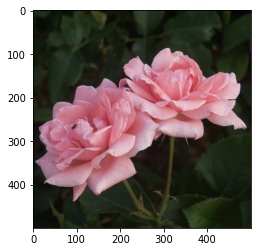

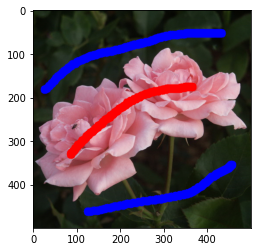

In [89]:
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB))

In [90]:
hc_c0 = get_h_j(h_0)
hc_c1 = get_h_j(h_1)

In [111]:
n     = radial_size
# Creo muestra aleatoria
alpha = np.random.sample(n)
mu    = np.random.sample((n, 3))

In [112]:
# Optimización para clase 0
params = {'alpha'    : alpha,
          'mu'       : mu, 
          'h_j'      : hc_c0,
          'sigma'    : sigma, 
          'iters'    : 500, 
          'tau_x'    : 1e-8,
          'tau_f'    : 1e-8,
          'tau_grad' : 1e-8,
          'method'   : 'BackTracking',
          'BackTracking' : {'alpha'    : 0.9,
                            'ro'       : 0.5,
                            'c1'       : 1e-4,
                            'max_iter' : 100  
                            }
          }

alpha_1, mu_1, f_hist, g_hist = optimization_iter(params)

Optimización para alpha
Optimización para mu
Iteración:  1 ,Valor de f:  1620858.42727682
Optimización para alpha
Optimización para mu
Iteración:  2 ,Valor de f:  557320.2344888925
Optimización para alpha
Optimización para mu
Iteración:  3 ,Valor de f:  501088.14289104886
Optimización para alpha
Optimización para mu
Iteración:  4 ,Valor de f:  494725.0617896594
Optimización para alpha
Optimización para mu
Iteración:  5 ,Valor de f:  489372.28038026794
Optimización para alpha
Optimización para mu
Iteración:  6 ,Valor de f:  484858.3620807156
Optimización para alpha
Optimización para mu
Iteración:  7 ,Valor de f:  481051.55429411086
Optimización para alpha
Optimización para mu
Iteración:  8 ,Valor de f:  477841.2353840382
Optimización para alpha
Optimización para mu
Iteración:  9 ,Valor de f:  475100.0785024343
Optimización para alpha
Optimización para mu
Iteración:  10 ,Valor de f:  472809.49291305186
Optimización para alpha
Optimización para mu
Iteración:  11 ,Valor de f:  470877.28411

In [ ]:
# 1599901

In [114]:
# Optimización para clase 1
params = {'alpha'    : alpha,
          'mu'       : mu, 
          'h_j'      : hc_c1,
          'sigma'    : sigma, 
          'iters'    : 500, 
          'tau_x'    : 1e-8,
          'tau_f'    : 1e-8,
          'tau_grad' : 1e-8,
          'method'   : 'BackTracking',
          'BackTracking' : {'alpha'    : 0.9,
                            'ro'       : 0.5,
                            'c1'       : 1e-4,
                            'max_iter' : 100  
                            }
          }
alpha_2, mu_2, f_hist1, g_hist1 = optimization_iter(params)

Optimización para alpha
Optimización para mu
Iteración:  1 ,Valor de f:  1274437.253256527
Optimización para alpha
Optimización para mu
Iteración:  2 ,Valor de f:  210007.1155059057
Optimización para alpha
Optimización para mu
Iteración:  3 ,Valor de f:  153903.45010253423
Optimización para alpha
Optimización para mu
Iteración:  4 ,Valor de f:  146693.29735574897
Optimización para alpha
Optimización para mu
Iteración:  5 ,Valor de f:  142624.57808658943
Optimización para alpha
Optimización para mu
Iteración:  6 ,Valor de f:  139017.25716370912
Optimización para alpha
Optimización para mu
Iteración:  7 ,Valor de f:  135661.9092215546
Optimización para alpha
Optimización para mu
Iteración:  8 ,Valor de f:  132516.6882089316
Optimización para alpha
Optimización para mu
Iteración:  9 ,Valor de f:  129578.82791230408
Optimización para alpha
Optimización para mu
Iteración:  10 ,Valor de f:  126821.91364145187
Optimización para alpha
Optimización para mu
Iteración:  11 ,Valor de f:  124249.77

In [ ]:
# 47146719

## Resultados

### Con F

Dimensiones de imagen:  (500, 500, 3)


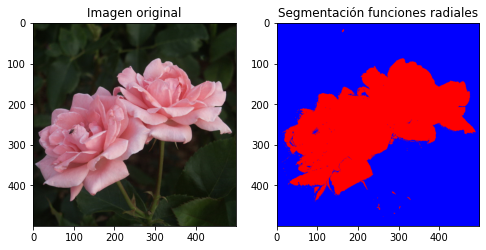

In [118]:
img2 = segmentation(img, nbins, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = sigma)
plot_img(img, img2, t = 'Imagen original', s = 'Segmentación funciones radiales')

### Con H

Dimensiones de imagen:  (500, 500, 3)


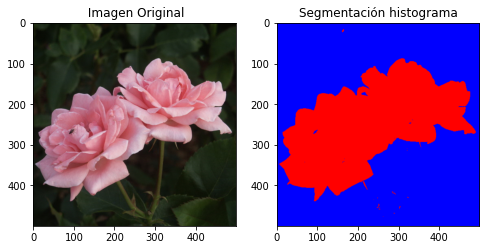

In [119]:
img3 = histogram_segmentation(img, nbins, h_0, h_1)

plot_img(img, img3, t1 =' Imagen Original', t2 ='Segmentación histograma')

# person1.bmp

In [120]:
img_dir    = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/person1/person1.bmp'
img_dr_seg = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/person1/Strokes.png'

In [121]:
h_0 = read_histogram('/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/person1/H_0.txt')
h_1 = read_histogram('/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/person1/H_1.txt')

In [122]:
img   = cv2.imread(img_dir)
img_s = cv2.imread(img_dr_seg)

(450, 600, 3)


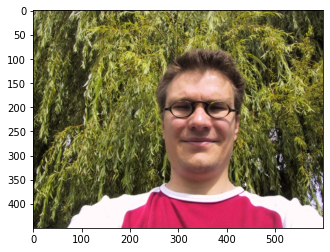

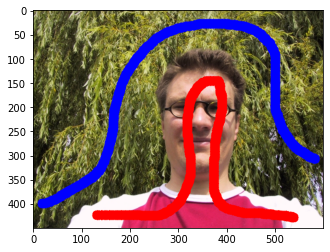

In [123]:
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB))

In [124]:
hc_c0 = get_h_j(h_0)
hc_c1 = get_h_j(h_1)

In [ ]:
n     = radial_size
alpha = np.random.sample(n)
mu    = np.random.sample((n, 3))

In [125]:
# Optimización para clase 0
params = {'alpha'    : alpha,
          'mu'       : mu, 
          'h_j'      : hc_c0,
          'sigma'    : sigma, 
          'iters'    : 500, 
          'tau_x'    : 1e-8,
          'tau_f'    : 1e-8,
          'tau_grad' : 1e-8,
          'method'   : 'BackTracking',
          'BackTracking' : {'alpha'    : 0.9,
                            'ro'       : 0.5,
                            'c1'       : 1e-4,
                            'max_iter' : 100  
                            }
          }
alpha_1, mu_1, f_hist, g_hist = optimization_iter(params)

Optimización para alpha
Optimización para mu
Iteración:  1 ,Valor de f:  18464878.95118252
Optimización para alpha
Optimización para mu
Iteración:  2 ,Valor de f:  16595361.309018016
Optimización para alpha
Optimización para mu
Iteración:  3 ,Valor de f:  16547213.765829993
Optimización para alpha
Optimización para mu
Iteración:  4 ,Valor de f:  16513734.07692473
Optimización para alpha
Optimización para mu
Iteración:  5 ,Valor de f:  16485750.273422271
Optimización para alpha
Optimización para mu
Iteración:  6 ,Valor de f:  16460951.508286975
Optimización para alpha
Optimización para mu
Iteración:  7 ,Valor de f:  16439535.62895587
Optimización para alpha
Optimización para mu
Iteración:  8 ,Valor de f:  16421081.045327574
Optimización para alpha
Optimización para mu
Iteración:  9 ,Valor de f:  16404063.422522336
Optimización para alpha
Optimización para mu
Iteración:  10 ,Valor de f:  16389342.467822012
Optimización para alpha
Optimización para mu
Iteración:  11 ,Valor de f:  16375791

In [126]:
# Optimización para clase 1
params = {'alpha'    : alpha,
          'mu'       : mu, 
          'h_j'      : hc_c1,
          'sigma'    : sigma, 
          'iters'    : 500, 
          'tau_x'    : 1e-8,
          'tau_f'    : 1e-8,
          'tau_grad' : 1e-8,
          'method'   : 'BackTracking',
          'BackTracking' : {'alpha'    : 0.9,
                            'ro'       : 0.5,
                            'c1'       : 1e-4,
                            'max_iter' : 100  
                            }
          }
alpha_2, mu_2, f_hist1, g_hist1 = optimization_iter(params)

Optimización para alpha
Optimización para mu
Iteración:  1 ,Valor de f:  2526851.3030397077
Optimización para alpha
Optimización para mu
Iteración:  2 ,Valor de f:  1817520.1183810441
Optimización para alpha
Optimización para mu
Iteración:  3 ,Valor de f:  1757603.8358350804
Optimización para alpha
Optimización para mu
Iteración:  4 ,Valor de f:  1739630.203704413
Optimización para alpha
Optimización para mu
Iteración:  5 ,Valor de f:  1725072.7680580968
Optimización para alpha
Optimización para mu
Iteración:  6 ,Valor de f:  1711846.184381098
Optimización para alpha
Optimización para mu
Iteración:  7 ,Valor de f:  1699320.1080881674
Optimización para alpha
Optimización para mu
Iteración:  8 ,Valor de f:  1687766.5729102562
Optimización para alpha
Optimización para mu
Iteración:  9 ,Valor de f:  1676845.3725760707
Optimización para alpha
Optimización para mu
Iteración:  10 ,Valor de f:  1666744.6962017408
Optimización para alpha
Optimización para mu
Iteración:  11 ,Valor de f:  1657220

## Resultados

### Segmentación con F

Dimensiones de imagen:  (450, 600, 3)


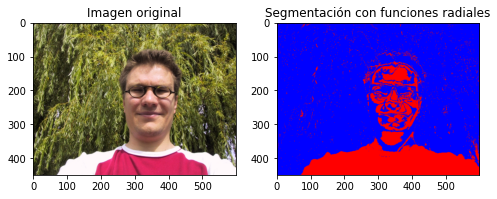

In [127]:
img2 = segmentation(img, nbins, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = sigma)
plot_img(img, img2, t = 'Imagen original', s = 'Segmentación con funciones radiales')

### Segmentación con H

Dimensiones de imagen:  (450, 600, 3)


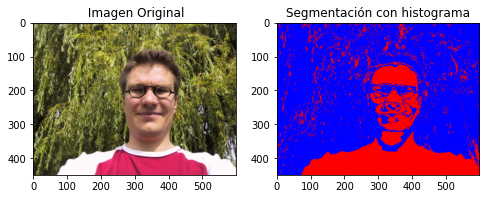

In [128]:
img3 = histogram_segmentation(img, nbins, h_0, h_1)

plot_img(img, img3, t =' Imagen Original', s ='Segmentación con histograma')

# flower.bmp

In [129]:
img_name    = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/flower/flower.bmp'
img_name2   = '/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/flower/Strokes.png'

In [130]:
h_0 = read_histogram('/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/flower/H_0.txt')
h_1 = read_histogram('/content/drive/MyDrive/CIMAT/Segundo_Semestre/Optimización/T08/src/flower/H_1.txt')

In [131]:
img   = cv2.imread(img_name)
img_s = cv2.imread(img_name2)

(450, 600, 3)


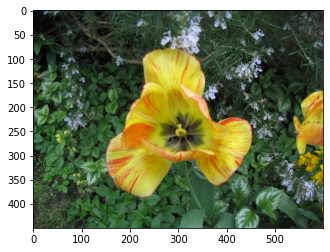

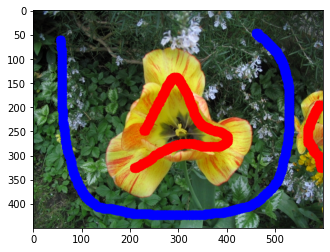

In [132]:
print(img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(img_s, cv2.COLOR_BGR2RGB))

In [133]:
hc_c0 = get_h_j(h_0)
hc_c1 = get_h_j(h_1)

In [134]:
n     = radial_size
alpha = np.random.sample(n)
mu    = np.random.sample((n, 3))

In [135]:
# Optimización para clase 0
# Optimización para clase 1
params = {'alpha'    : alpha,
          'mu'       : mu, 
          'h_j'      : hc_c0,
          'sigma'    : sigma, 
          'iters'    : 500, 
          'tau_x'    : 1e-8,
          'tau_f'    : 1e-8,
          'tau_grad' : 1e-8,
          'method'   : 'BackTracking',
          'BackTracking' : {'alpha'    : 0.9,
                            'ro'       : 0.5,
                            'c1'       : 1e-4,
                            'max_iter' : 100  
                            }
          }

alpha_1, mu_1, f_hist, g_hist = optimization_iter(params)

Optimización para alpha
Optimización para mu
Iteración:  1 ,Valor de f:  3675695.540637151
Optimización para alpha
Optimización para mu
Iteración:  2 ,Valor de f:  754671.9638970012
Optimización para alpha
Optimización para mu
Iteración:  3 ,Valor de f:  717544.4123723758
Optimización para alpha
Optimización para mu
Iteración:  4 ,Valor de f:  716946.5891179709
Optimización para alpha
Optimización para mu
Iteración:  5 ,Valor de f:  716365.1541671621
Optimización para alpha
Optimización para mu
Iteración:  6 ,Valor de f:  715806.4236449228
Optimización para alpha
Optimización para mu
Iteración:  7 ,Valor de f:  715266.6964683526
Optimización para alpha
Optimización para mu
Iteración:  8 ,Valor de f:  714740.2283726973
Optimización para alpha
Optimización para mu
Iteración:  9 ,Valor de f:  714234.4639085435
Optimización para alpha
Optimización para mu
Iteración:  10 ,Valor de f:  713737.689931952
Optimización para alpha
Optimización para mu
Iteración:  11 ,Valor de f:  713258.878409071

In [136]:
# Optimización para clase 1
params = {'alpha'    : alpha,
          'mu'       : mu, 
          'h_j'      : hc_c1,
          'sigma'    : sigma, 
          'iters'    : 500, 
          'tau_x'    : 1e-8,
          'tau_f'    : 1e-8,
          'tau_grad' : 1e-8,
          'method'   : 'BackTracking',
          'BackTracking' : {'alpha'    : 0.9,
                            'ro'       : 0.5,
                            'c1'       : 1e-4,
                            'max_iter' : 100  
                            }
          }

alpha_2, mu_2, f_hist1, g_hist1 = optimization_iter(params)

Optimización para alpha
Optimización para mu
Iteración:  1 ,Valor de f:  929321.5808752262
Optimización para alpha
Optimización para mu
Iteración:  2 ,Valor de f:  677803.3202947411
Optimización para alpha
Optimización para mu
Iteración:  3 ,Valor de f:  608843.7789888347
Optimización para alpha
Optimización para mu
Iteración:  4 ,Valor de f:  558293.0107583818
Optimización para alpha
Optimización para mu
Iteración:  5 ,Valor de f:  516278.71149869624
Optimización para alpha
Optimización para mu
Iteración:  6 ,Valor de f:  481669.83804656356
Optimización para alpha
Optimización para mu
Iteración:  7 ,Valor de f:  452907.79938766675
Optimización para alpha
Optimización para mu
Iteración:  8 ,Valor de f:  428985.9610215585
Optimización para alpha
Optimización para mu
Iteración:  9 ,Valor de f:  409076.0588907071
Optimización para alpha
Optimización para mu
Iteración:  10 ,Valor de f:  392493.64009691
Optimización para alpha
Optimización para mu
Iteración:  11 ,Valor de f:  378672.7439110

Dimensiones de imagen:  (450, 600, 3)


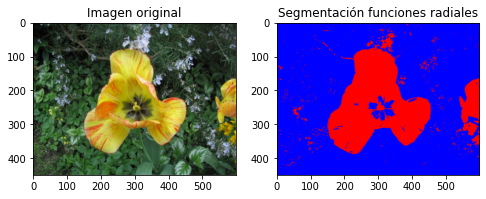

In [137]:
img2 = segmentation(img, nbins, alpha_1, mu_1, alpha_2, mu_2, epsilon = 0.01, sigma = sigma)
plot_img(img, img2, t = 'Imagen original', s = 'Segmentación con funciones radiales')

Dimensiones de imagen:  (450, 600, 3)


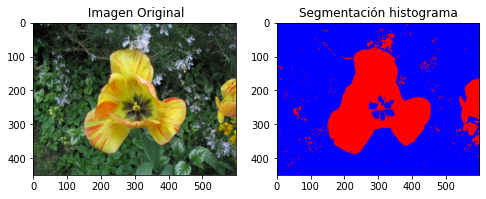

In [138]:
img3 = histogram_segmentation(img, nbins, h_0, h_1)

plot_img(img, img3, t = ' Imagen Original', s = 'Segmentación con histograma')